# Análisis descriptivo

In [650]:
import pandas as pd
import matplotlib.pyplot as plt

In [651]:
save_path = r'C:\Users\ctrujils\eficiencia_promocional\maestro_clientes_12UM_cluster.parquet'
maestor_clientes=pd.read_parquet(save_path)

In [652]:

path = r'C:\Users\ctrujils\eficiencia_promocional\order_detail_sorted_cluster.parquet'
order_detail_sorted = pd.read_parquet(path)

In [653]:
order_detail_sorted.shape

(689818, 24)

In [654]:
order_detail_sorted=order_detail_sorted[order_detail_sorted['Sellout']>0]

###### Eliminamos de nuestro análisis a Voldis Baleares y Ceres

In [655]:

order_detail_sorted =order_detail_sorted[~order_detail_sorted['NameDistributor'].isin(['Ceres', 'Voldis Baleares'])]

In [656]:
order_detail_sorted.shape

(478395, 24)

### Filtro de segmentación de pdvs

Impacto de promociones por PDV y cupón

In [657]:
order_detail_sorted['CouponDiscountAmt'] = pd.to_numeric(order_detail_sorted['CouponDiscountAmt'], errors='coerce').fillna(0)
kpis_por_pdv_promo = order_detail_sorted.groupby(['PointOfSaleId', 'CouponCode']).agg(
    impacto_promociones=pd.NamedAgg(column='CouponDiscountAmt', aggfunc='sum'), #impacto monetario por cupones aplicados por PDV
    # total_productos_comprados=pd.NamedAgg(column='Amount', aggfunc='sum') # total de la cantidad de productos comprados por cada PDV
).reset_index()

In [658]:
kpis_por_pdv_promo.sort_values('impacto_promociones',ascending=False).head(30)

,PointOfSaleId,CouponCode,impacto_promociones
6668,CLI0026803,Regreso20,348.000000
6396,CLI0026381,REGRESO20,328.799988
8816,CLI0029258,Regreso20,260.000000
1173,102232,Mereces15,225.000000
7133,CLI0027298,REGRESO20,220.000000
12912,CLI0034240,REGRESO20,201.500000
1330,13266,HAPPY10,200.000000
9316,CLI0029840,BAR10,200.000000
1360,13686,BAR10,200.000000
2672,CLI0020482,HAPPY10,200.000000


# PDVs dormidos en la plataforma


In [659]:
last_order_dates = order_detail_sorted.groupby(['PointOfSaleId', 'NameDistributor'])['OrderDate'].max().reset_index()
last_order_dates.columns = ['PointOfSaleId','NameDistributor', 'LastOrderDate']


In [660]:
df_orders_count = order_detail_sorted.groupby('PointOfSaleId').size().reset_index(name='NumberOfOrders')


df_orders_count


,PointOfSaleId,NumberOfOrders
0,00134,77
1,00162,75
2,00163,77
3,00175,1
4,00181,1
...,...,...
18131,CLI0051210,5
18132,CLI0051211,2
18133,CLI0051212,15
18134,F003394,2


In [661]:

order_detail_sorted = pd.merge(order_detail_sorted, df_orders_count, on='PointOfSaleId', how='left')

In [662]:
online_orders = order_detail_sorted[order_detail_sorted['Origin'] == 'Online']
last_online_order_dates = online_orders.groupby(['PointOfSaleId', 'NameDistributor'])['OrderDate'].max().reset_index()
last_online_order_dates.columns = ['PointOfSaleId', 'NameDistributor', 'LastOnlineOrderDate']

In [663]:
last_order_dates_general = pd.merge(last_order_dates, last_online_order_dates, on=['PointOfSaleId',  'NameDistributor'], how='left')
last_order_dates_general = pd.merge(last_order_dates_general, df_orders_count, on='PointOfSaleId', how='left')

In [664]:
last_order_dates_general['DaysBetweenLastOrderAndLastOnline'] = (last_order_dates_general['LastOrderDate'] - last_order_dates_general['LastOnlineOrderDate']).dt.days

In [665]:
# last_order_dates_general=last_order_dates_general.dropna() 

In [666]:
last_order_dates_general=last_order_dates_general.sort_values(by='DaysBetweenLastOrderAndLastOnline', ascending=False)

In [667]:
last_order_dates_general = last_order_dates_general.dropna(subset=['LastOnlineOrderDate'])

In [668]:
last_order_dates_general.columns

Index(['PointOfSaleId', 'NameDistributor', 'LastOrderDate',
       'LastOnlineOrderDate', 'NumberOfOrders',
       'DaysBetweenLastOrderAndLastOnline'],
      dtype='object')

<Axes: >

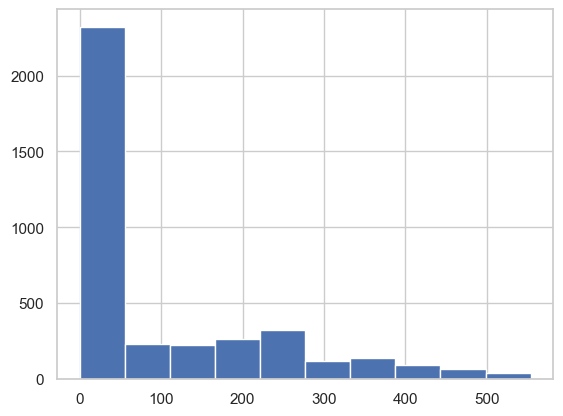

In [669]:
last_order_dates_general['DaysBetweenLastOrderAndLastOnline'].hist()

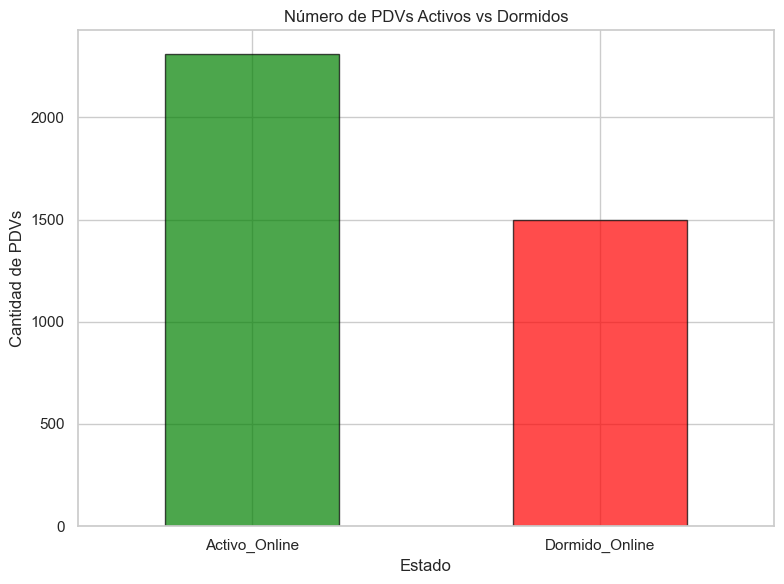

In [670]:

last_order_dates_general['Estado'] = last_order_dates_general['DaysBetweenLastOrderAndLastOnline'].apply(lambda x: 'Activo_Online' if x <= 50 else 'Dormido_Online')
estado_counts = last_order_dates_general['Estado'].value_counts()

plt.figure(figsize=(8, 6))
estado_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7, edgecolor='black')
plt.title('Número de PDVs Activos vs Dormidos')
plt.xlabel('Estado')
plt.ylabel('Cantidad de PDVs')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [672]:

order_detail_sorted=pd.merge(order_detail_sorted,last_order_dates_general, on=['PointOfSaleId','NameDistributor'], how='left')

Aplico filtro de > 50 días entre compras considero dormido en la plataforma

In [635]:
pdvs_unicos = last_order_dates_general['PointOfSaleId'].unique()

lista_pdvs = pdvs_unicos.tolist()

In [636]:
df_filtered = order_detail_sorted[order_detail_sorted['PointOfSaleId'].isin(lista_pdvs)]

In [637]:
def filter_coupons(coupons):
    return [coupon for coupon in coupons if pd.notna(coupon)]

# Filtrar los registros online
df_filtered_online = df_filtered[df_filtered['Origin'] == 'Online']

resultados_dormidos = df_filtered.groupby('PointOfSaleId').agg(
    UniqueCoupons=('CouponCode', lambda x: filter_coupons(x.unique())),  # Lista de códigos de cupones únicos, sin None/NaN
    NumberOfUniqueCoupons=('CouponCode', lambda x: x.dropna().nunique()),  # Número de cupones únicos sin considerar None/NaN
    CouponDiscountAmt=('CouponDiscountAmt', 'sum'),  # Suma total del monto de descuento
    SelloutGeneral=('Sellout', 'sum')  # Suma total de las ventas (general)
).reset_index()

# Agrupar por 'PointOfSaleId' para obtener el Sellout solo de los pedidos online
sellout_online = df_filtered_online.groupby('PointOfSaleId').agg(
    SelloutOnline=('Sellout', 'sum')  # Suma total de las ventas solo de origen online
).reset_index()

# Hacer un merge para agregar el 'SelloutOnline' al DataFrame 'resultados_dormidos'
resultados_dormidos = pd.merge(resultados_dormidos, sellout_online, on='PointOfSaleId', how='left')

# Rellenar valores NaN en 'SelloutOnline' con 0 (si el PDV no tiene ventas online)
resultados_dormidos['SelloutOnline'] = resultados_dormidos['SelloutOnline'].fillna(0)
resultados_dormidos=resultados_dormidos[resultados_dormidos['CouponDiscountAmt']>0 ]
resultados_dormidos['Ratio_Cupones_Sellout'] = resultados_dormidos['SelloutOnline'] / resultados_dormidos['CouponDiscountAmt']
resultados_dormidos['Ratio_Cupones_Sellout'] = resultados_dormidos['Ratio_Cupones_Sellout'].fillna(0)  # Reemplazar NaN por 0 para evitar errores de división

resultados_dormidos_path=  r'C:\Users\ctrujils\resultados_pdv_dormidos.xlsx'
resultados_dormidos.to_excel(resultados_dormidos_path)


In [638]:
resultados_dormidos

,PointOfSaleId,UniqueCoupons,NumberOfUniqueCoupons,CouponDiscountAmt,SelloutGeneral,SelloutOnline,Ratio_Cupones_Sellout
0,100005,"[PASCUA15, PRIMAVERA20, VOLDIS15%, HISTORIAS10...",5,403.639996,2528.709999,2528.709999,6.264766
1,100131,"[PRIMAVERA20, VOLDIS15%, Verano15, BAR10]",4,78.129999,414.890003,414.890003,5.310252
2,100141,[Bar10],1,50.000000,1606.490052,1606.490052,32.129801
3,100150,[BIENVENIDA20],1,100.000000,512.450012,512.450012,5.124500
4,100152,"[BIENVENIDA20, VOLDIS15%, Mereces15]",3,69.160000,347.579994,347.579994,5.025737
...,...,...,...,...,...,...,...
3802,CLI0051066,[MERECES15],1,25.129999,3583.680006,1464.990006,58.296461
3803,CLI0051071,[MERECES15],1,100.570000,6817.259984,569.889984,5.666600
3804,CLI0051127,[Mereces15],1,75.000000,2121.709985,458.859985,6.118133
3805,F003394,"[BIENVENIDA20DTO, VOLDIS15%]",2,114.310001,615.849991,615.849991,5.387543


In [639]:
# resultados_dormidos[resultados_dormidos['Ratio_Cupones_Sellout']>500]

In [640]:
# a=order_detail_sorted[order_detail_sorted['PointOfSaleId']=='CLI0025203']

In [641]:
roi_dormidos_stats = resultados_dormidos['Ratio_Cupones_Sellout'].describe()
roi_dormidos_stats

count    3639.000000
mean       10.513347
std        15.778697
min         0.507000
25%         5.680462
50%         7.816484
75%        10.717229
max       607.073928
Name: Ratio_Cupones_Sellout, dtype: float64

# Frecuencia de compra online

In [642]:
online_orders

,Code,OrderDate,Sellout,CodeProduct,Name,NameDistributor,PointOfSaleId,CouponCode,CouponDiscountAmt,CouponDiscountPct,...,Frequency_online,Coupon_type,PctgCouponUsed,DaysBetweenPurchases,CumulativeAvgDaysBetweenPurchases,IsOnline,LastPurchaseOnline,Digitalizacion,ForwardOnline,NumberOfOrders
42057,9401125,2024-06-07,215.220001,"[042_bebicer, 22_bebicer, 25109_bebicer]",OASIS NEGRO,Bebicer,1533,BIENVENIDA20,53.799999,20.0,...,1.0,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1
42058,9400855,2024-05-23,820.890015,"[06_bebicer, 042_bebicer, 3810_bebicer, 3802_b...",VEN Y VERAS - CERVECERIA,Bebicer,1543,SEGUNDOPEDIDO15%,75.000000,15.0,...,1.0,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1
42059,9401068,2024-06-05,329.549988,"[22_bebicer, 20_bebicer, 23_bebicer, 54_bebice...",LA GALERIA - BAR,Bebicer,1583,BIENVENIDA20,82.389999,20.0,...,1.0,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1
42060,9401187,2024-06-12,352.920013,"[23_bebicer, 51_bebicer, 25109_bebicer, 2004_b...",LA TRINI - BAR,Bebicer,1611,BIENVENIDA20,88.230003,20.0,...,1.0,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1
42061,9401291,2024-06-19,1304.469971,"[20_bebicer, 22_bebicer, 042_bebicer, 23_bebic...",EL SALERO DE MING,Bebicer,1709,SEGUNDOPEDIDO15%,75.000000,15.0,...,1.0,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477929,FP24-040527,2024-06-18,142.389999,"[2030_voldisvalencia, 2020_voldisvalencia, 209...",KA MONLLU,Voldis Valencia,CLI0051066,MERECES15,25.129999,15.0,...,7.0,Porcentual,3.973290,7.0,9.333333,True,True,6.0,True,21
477932,FP24-046239,2024-07-09,171.130005,"[PRD0005412_voldisvalencia, PRD0005421_voldisv...",KA MONLLU,Voldis Valencia,CLI0051066,None,0.000000,0.0,...,7.0,NoCupon,3.973290,21.0,11.000000,True,False,5.0,True,21
477985,FP24-040496,2024-06-17,376.049988,"[3096_voldisvalencia, 2090_voldisvalencia, 242...",PUB MAMBA,Voldis Valencia,CLI0051071,MERECES15,66.360001,15.0,...,2.0,Porcentual,8.359517,0.0,0.000000,True,False,1.0,True,42
477989,FP24-042395,2024-06-24,193.839996,"[24207_voldisvalencia, 1995_voldisvalencia, 55...",PUB MAMBA,Voldis Valencia,CLI0051071,MERECES15,34.209999,15.0,...,2.0,Porcentual,8.359517,7.0,3.500000,True,False,2.0,True,42


In [643]:
# ### Filtro solo ONLINE
# online_orders = order_detail_sorted[order_detail_sorted['Origin'] == 'Online']

# 2. Calcular la frecuencia online por cada PointOfSaleId
frequency_online_per_pdv = online_orders.groupby(['PointOfSaleId', 'NameDistributor']).size().reset_index(name='FrequencyOnline')

# 3. Calcular los percentiles para definir los segmentos (cuartiles personalizados)
percentiles = frequency_online_per_pdv['FrequencyOnline'].quantile([0.1, 0.5, 0.9]).values

# 4. Función para clasificar los PDVs en cuartiles personalizados
def clasificar_frecuencia(frequency):
    if frequency > percentiles[2]:
        return 'A'  # Top 10%
    elif percentiles[1] < frequency <= percentiles[2]:
        return 'B'  # 40% Superior
    elif percentiles[0] < frequency <= percentiles[1]:
        return 'C'  # 40% Inferior
    else:
        return 'D'  # Bottom 10%

# 5. Aplicar la clasificación
frequency_online_per_pdv['SegmentoFrecuencia'] = frequency_online_per_pdv['FrequencyOnline'].apply(clasificar_frecuencia)


In [674]:
online_orders=pd.merge(online_orders, frequency_online_per_pdv[['PointOfSaleId', 'NameDistributor' ,'SegmentoFrecuencia']], on=['PointOfSaleId','NameDistributor' ], how='left')

In [675]:
online_orders

,Code,OrderDate,Sellout,CodeProduct,Name,NameDistributor,PointOfSaleId,CouponCode,CouponDiscountAmt,CouponDiscountPct,...,Coupon_type,PctgCouponUsed,DaysBetweenPurchases,CumulativeAvgDaysBetweenPurchases,IsOnline,LastPurchaseOnline,Digitalizacion,ForwardOnline,NumberOfOrders,SegmentoFrecuencia
0,9401125,2024-06-07,215.220001,"[042_bebicer, 22_bebicer, 25109_bebicer]",OASIS NEGRO,Bebicer,1533,BIENVENIDA20,53.799999,20.0,...,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1,D
1,9400855,2024-05-23,820.890015,"[06_bebicer, 042_bebicer, 3810_bebicer, 3802_b...",VEN Y VERAS - CERVECERIA,Bebicer,1543,SEGUNDOPEDIDO15%,75.000000,15.0,...,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1,D
2,9401068,2024-06-05,329.549988,"[22_bebicer, 20_bebicer, 23_bebicer, 54_bebice...",LA GALERIA - BAR,Bebicer,1583,BIENVENIDA20,82.389999,20.0,...,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1,D
3,9401187,2024-06-12,352.920013,"[23_bebicer, 51_bebicer, 25109_bebicer, 2004_b...",LA TRINI - BAR,Bebicer,1611,BIENVENIDA20,88.230003,20.0,...,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1,D
4,9401291,2024-06-19,1304.469971,"[20_bebicer, 22_bebicer, 042_bebicer, 23_bebic...",EL SALERO DE MING,Bebicer,1709,SEGUNDOPEDIDO15%,75.000000,15.0,...,Porcentual,100.000000,0.0,0.000000,True,False,1.0,True,1,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34074,FP24-040527,2024-06-18,142.389999,"[2030_voldisvalencia, 2020_voldisvalencia, 209...",KA MONLLU,Voldis Valencia,CLI0051066,MERECES15,25.129999,15.0,...,Porcentual,3.973290,7.0,9.333333,True,True,6.0,True,21,B
34075,FP24-046239,2024-07-09,171.130005,"[PRD0005412_voldisvalencia, PRD0005421_voldisv...",KA MONLLU,Voldis Valencia,CLI0051066,None,0.000000,0.0,...,NoCupon,3.973290,21.0,11.000000,True,False,5.0,True,21,B
34076,FP24-040496,2024-06-17,376.049988,"[3096_voldisvalencia, 2090_voldisvalencia, 242...",PUB MAMBA,Voldis Valencia,CLI0051071,MERECES15,66.360001,15.0,...,Porcentual,8.359517,0.0,0.000000,True,False,1.0,True,42,C
34077,FP24-042395,2024-06-24,193.839996,"[24207_voldisvalencia, 1995_voldisvalencia, 55...",PUB MAMBA,Voldis Valencia,CLI0051071,MERECES15,34.209999,15.0,...,Porcentual,8.359517,7.0,3.500000,True,False,2.0,True,42,C


In [678]:
order_detail_sorted

,Code,OrderDate,Sellout,CodeProduct,Name,NameDistributor,PointOfSaleId,CouponCode,CouponDiscountAmt,CouponDiscountPct,...,IsOnline,LastPurchaseOnline,Digitalizacion,ForwardOnline,NumberOfOrders_x,LastOrderDate,LastOnlineOrderDate,NumberOfOrders_y,DaysBetweenLastOrderAndLastOnline,Estado
0,3017605,2023-01-05,48.731310,"[LOG, 7712, CH0017, 804, CH0021, CH0022]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN
1,3017767,2023-01-13,86.880409,"[CH0030, AGENDA, GR002, PRGRANIN63, 804, CH001...",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN
2,3017926,2023-01-20,42.959549,"[7712, 655, CH0017, CH0005, 804, LOG, CH0014]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN
3,3018099,2023-01-27,31.580409,"[CH0005, LOG, CH0017, 804, 7712, CH0030]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN
4,3018266,2023-02-03,50.711448,"[804, LOG, 655, CH0017, CH0022, CH0005, 7712]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478390,FP24-040-405,2024-06-17,134.770000,"[PRD0000618, PRD0013878, PRD0014119, PRD000840...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN
478391,FP24-040-952,2024-06-18,167.130000,"[PRD0003573, PRD0012779, PRD0008469, PRD000088...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN
478392,FP24-044-076,2024-07-01,308.070000,"[PRD0012419, PRD0013195, PRD0012766, PRD000357...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN
478393,FP24-045-906,2024-07-08,68.980000,"[PRD0012388, PRD0012766, PRD0013189]",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN


In [679]:
online_orders.shape

(34079, 26)

In [680]:
order_detail_sorted=pd.merge(order_detail_sorted, online_orders[['PointOfSaleId','NameDistributor' ,'Code','SegmentoFrecuencia']], on=['PointOfSaleId','Code','NameDistributor'], how='left')

,Code,OrderDate,Sellout,CodeProduct,Name,NameDistributor,PointOfSaleId,CouponCode,CouponDiscountAmt,CouponDiscountPct,...,LastPurchaseOnline,Digitalizacion,ForwardOnline,NumberOfOrders_x,LastOrderDate,LastOnlineOrderDate,NumberOfOrders_y,DaysBetweenLastOrderAndLastOnline,Estado,SegmentoFrecuencia
0,3017605,2023-01-05,48.731310,"[LOG, 7712, CH0017, 804, CH0021, CH0022]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN,NaN
1,3017767,2023-01-13,86.880409,"[CH0030, AGENDA, GR002, PRGRANIN63, 804, CH001...",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN,NaN
2,3017926,2023-01-20,42.959549,"[7712, 655, CH0017, CH0005, 804, LOG, CH0014]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN,NaN
3,3018099,2023-01-27,31.580409,"[CH0005, LOG, CH0017, 804, 7712, CH0030]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN,NaN
4,3018266,2023-02-03,50.711448,"[804, LOG, 655, CH0017, CH0022, CH0005, 7712]",EL CERRO DE LOS OLIVOS,Bebicer,00134,None,0.0,0.0,...,False,0.0,False,77,NaT,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478470,FP24-040-405,2024-06-17,134.770000,"[PRD0000618, PRD0013878, PRD0014119, PRD000840...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN,NaN
478471,FP24-040-952,2024-06-18,167.130000,"[PRD0003573, PRD0012779, PRD0008469, PRD000088...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN,NaN
478472,FP24-044-076,2024-07-01,308.070000,"[PRD0012419, PRD0013195, PRD0012766, PRD000357...",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN,NaN
478473,FP24-045-906,2024-07-08,68.980000,"[PRD0012388, PRD0012766, PRD0013189]",BIOKO PARADISE,Voldis Valencia,CLI0051212,None,0.0,0.0,...,False,0.0,False,15,NaT,NaT,NaN,NaN,NaN,NaN


In [681]:
online_orders.SegmentoFrecuencia.unique()

array(['D', 'C', 'B', 'A'], dtype=object)

In [682]:
online_orders['Origin'].unique()

array(['Online'], dtype=object)

In [683]:
# Agrupar por 'SegmentoFrecuencia' y calcular estadísticas
segmento_stats = online_orders.groupby('SegmentoFrecuencia').agg(
    NumeroPDVs=('PointOfSaleId', 'nunique'),
    TotalCouponDiscountAmt=('CouponDiscountAmt', 'sum'),
    PromedioCouponDiscountAmt=('CouponDiscountAmt', 'mean'),
    TotalSelloutOnline=('Sellout', 'sum'),
    PromedioSelloutOnline=('Sellout', 'mean')
).reset_index()



### Sacar promedios sin 0 para coupondiscountAmt 

cupon_sin0 = online_orders[online_orders['CouponDiscountAmt'] > 0]

# 2. Calcular el promedio de 'CouponDiscountAmt' sin contar los valores que son 0 para cada SegmentoFrecuencia
promedio_cupon_sin0_segmento = cupon_sin0.groupby('SegmentoFrecuencia')['CouponDiscountAmt'].mean().reset_index()

# Renombrar la columna para evitar conflicto al hacer el merge
promedio_cupon_sin0_segmento = promedio_cupon_sin0_segmento.rename(columns={'CouponDiscountAmt': 'PromedioCouponDiscountAmtSin0'})

# 3. Hacer el merge para agregar la nueva columna al DataFrame 'segmento_stats'
segmento_stats = pd.merge(segmento_stats, promedio_cupon_sin0_segmento, on='SegmentoFrecuencia', how='left')

segmento_stats


,SegmentoFrecuencia,NumeroPDVs,TotalCouponDiscountAmt,PromedioCouponDiscountAmt,TotalSelloutOnline,PromedioSelloutOnline,PromedioCouponDiscountAmtSin0
0,A,363,324261.890000,23.944904,5.454968e+06,402.818522,37.801573
1,B,1315,411020.929966,26.661970,4.100206e+06,265.970829,33.895838
2,C,1357,126797.999960,29.162373,9.856193e+05,226.683379,36.310997
3,D,773,27500.999987,35.576973,1.766007e+05,228.461501,40.985097


In [684]:
segmento_stats['TotalCouponDiscountAmt'].sum()

889581.8199128849

In [685]:
online_orders['CouponDiscountAmt'].describe()

count    34079.000000
mean        26.103519
std         27.176602
min          0.000000
25%          0.000000
50%         20.000000
75%         41.730000
max        328.000000
Name: CouponDiscountAmt, dtype: float64

Cálculo del retorno de inversión en cupones

In [686]:
# Calcular el retorno de inversión en cupones para cada segmento
segmento_stats['Ratio_Cupones_Sellout'] = segmento_stats['TotalSelloutOnline'] / segmento_stats['TotalCouponDiscountAmt'] ## Hacerlo sobre total online

print(segmento_stats[['SegmentoFrecuencia', 'Ratio_Cupones_Sellout']])


  SegmentoFrecuencia  Ratio_Cupones_Sellout
0                  A              16.822724
1                  B               9.975663
2                  C               7.773146
3                  D               6.421612


Segmento A --> cada euro invertido en cupones genera 17 unidades de venta. Los PDVs de alta frecuencia online (Grupo A) son los más rentables en términos de retorno por cupones.
Puede ser que la inversión en cupones en estos PDVs está siendo altamente efectiva y vale la pena seguir enfocando recursos en mantener y aumentar su actividad. -->

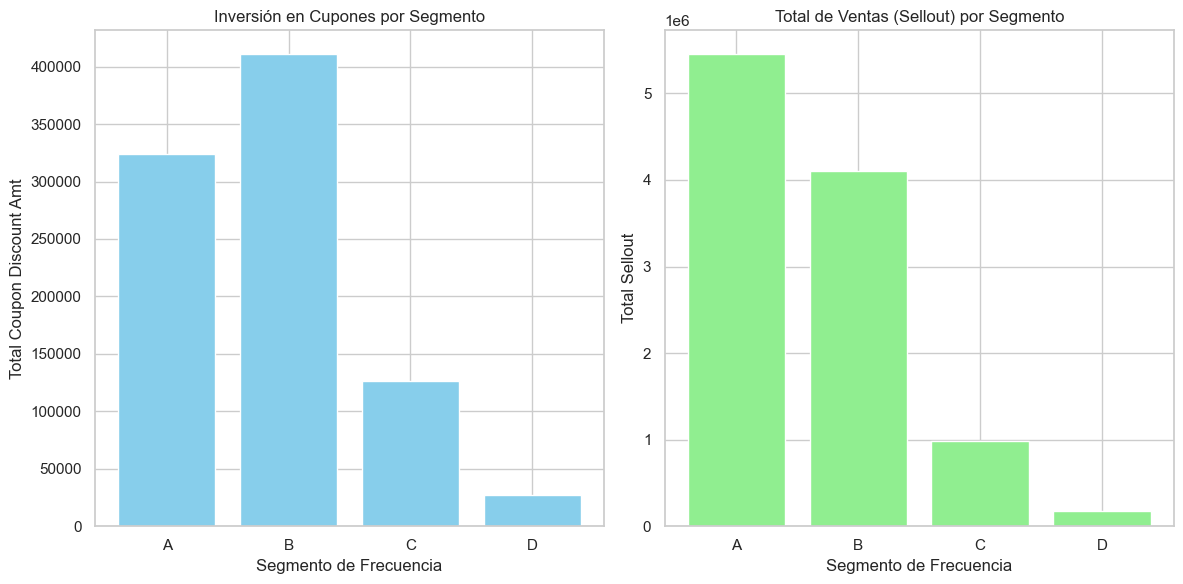

In [687]:
import matplotlib.pyplot as plt

# Crear una figura para comparar el Total de CouponDiscountAmt y el Total de Sellout por segmento
plt.figure(figsize=(12, 6))

# Gráfico de barras para TotalCouponDiscountAmt
plt.subplot(1, 2, 1)
plt.bar(segmento_stats['SegmentoFrecuencia'], segmento_stats['TotalCouponDiscountAmt'], color='skyblue')
plt.title('Inversión en Cupones por Segmento')
plt.xlabel('Segmento de Frecuencia')
plt.ylabel('Total Coupon Discount Amt')

# Gráfico de barras para TotalSellout
plt.subplot(1, 2, 2)
plt.bar(segmento_stats['SegmentoFrecuencia'], segmento_stats['TotalSelloutOnline'], color='lightgreen')
plt.title('Total de Ventas (Sellout) por Segmento')
plt.xlabel('Segmento de Frecuencia')
plt.ylabel('Total Sellout')

plt.tight_layout()
plt.show()


# Volumen de facturación

In [688]:

facturacion_online_pdv = online_orders.groupby('PointOfSaleId')['Sellout'].sum().reset_index()
facturacion_online_pdv = facturacion_online_pdv.rename(columns={'Sellout': 'TotalFacturacionOnline'})
percentiles = facturacion_online_pdv['TotalFacturacionOnline'].quantile([0.1, 0.5, 0.9]).values


In [689]:
# Función para clasificar los PDVs en cuartiles personalizados según el volumen de facturación online
def clasificar_facturacion_online(total_facturacion_online):
    if total_facturacion_online >= percentiles[2]:
        return 'A'  # Top 10% de facturación online
    elif percentiles[1] <= total_facturacion_online < percentiles[2]:
        return 'B'  # Del 50% al 90%
    elif percentiles[0] <= total_facturacion_online < percentiles[1]:
        return 'C'  # Del 10% al 50%
    else:
        return 'D'  # Bottom 10%

# Aplicar la clasificación para cada PDV
facturacion_online_pdv['SegmentoFacturacionOnline'] = facturacion_online_pdv['TotalFacturacionOnline'].apply(clasificar_facturacion_online)
### Mergearlo al DF 


In [690]:
order_detail_sorted = pd.merge(order_detail_sorted, facturacion_online_pdv[['PointOfSaleId', 'SegmentoFacturacionOnline']], on='PointOfSaleId', how='left')

In [692]:
# Agrupar por el segmento 'SegmentoFacturacionOnline' para calcular las métricas
segmento_facturacion_stats = order_detail_sorted.groupby('SegmentoFacturacionOnline').agg(
    NumeroPDVs=('PointOfSaleId', 'nunique'),  # Número de PDVs en cada segmento
    TotalCouponDiscountAmt=('CouponDiscountAmt', 'sum'),  # Gasto total en cupones
    PromedioCouponDiscountAmt=('CouponDiscountAmt', 'mean'),  # Gasto promedio en cupones
    TotalSelloutOnline=('Sellout', 'sum'),  # Facturación total
    PromedioSelloutOnline=('Sellout', 'mean')  # Facturación promedio
).reset_index()




In [693]:
# Filtrar los registros con 'CouponDiscountAmt' > 0
cupon_sin0 = order_detail_sorted[order_detail_sorted['CouponDiscountAmt'] > 0]

# Agrupar por 'SegmentoFacturacionOnline' y calcular el promedio de 'CouponDiscountAmt' sin contar los valores que son 0
promedio_cupon_sin0_segmento = cupon_sin0.groupby('SegmentoFacturacionOnline')['CouponDiscountAmt'].mean().reset_index()

# Renombrar la columna para evitar conflicto al hacer el merge
promedio_cupon_sin0_segmento = promedio_cupon_sin0_segmento.rename(columns={'CouponDiscountAmt': 'PromedioCouponDiscountAmtSin0'})

# Hacer el merge para agregar la nueva columna 'PromedioCouponDiscountAmtSin0' al DataFrame 'segmento_facturacion_stats'
segmento_facturacion_stats = pd.merge(segmento_facturacion_stats, promedio_cupon_sin0_segmento, on='SegmentoFacturacionOnline', how='left')




In [694]:
segmento_facturacion_stats

,SegmentoFacturacionOnline,NumeroPDVs,TotalCouponDiscountAmt,PromedioCouponDiscountAmt,TotalSelloutOnline,PromedioSelloutOnline,PromedioCouponDiscountAmtSin0
0,A,381,352495.630057,10.848690,1.519328e+07,467.600590,41.819389
1,B,1523,447331.299922,6.241977,2.164452e+07,302.023596,35.247916
2,C,1522,86077.019937,1.868518,8.964439e+06,194.595682,25.316771
3,D,381,3757.839996,0.498983,7.799373e+05,103.563579,10.798391


C:\Users\ctrujils\AppData\Local\Temp\ipykernel_3648\2232983473.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SegmentoFacturacionOnline', y='TotalCouponDiscountAmt', data=segmento_facturacion_stats, palette='cool')
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` in

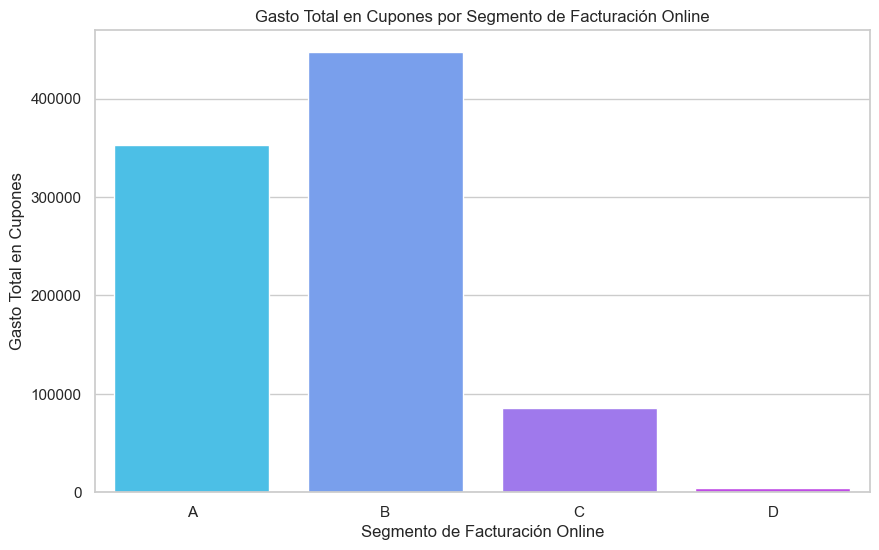

C:\Users\ctrujils\AppData\Local\Temp\ipykernel_3648\2232983473.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SegmentoFacturacionOnline', y='Ratio_Cupones_Sellout', data=segmento_facturacion_stats, palette='autumn')
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` 

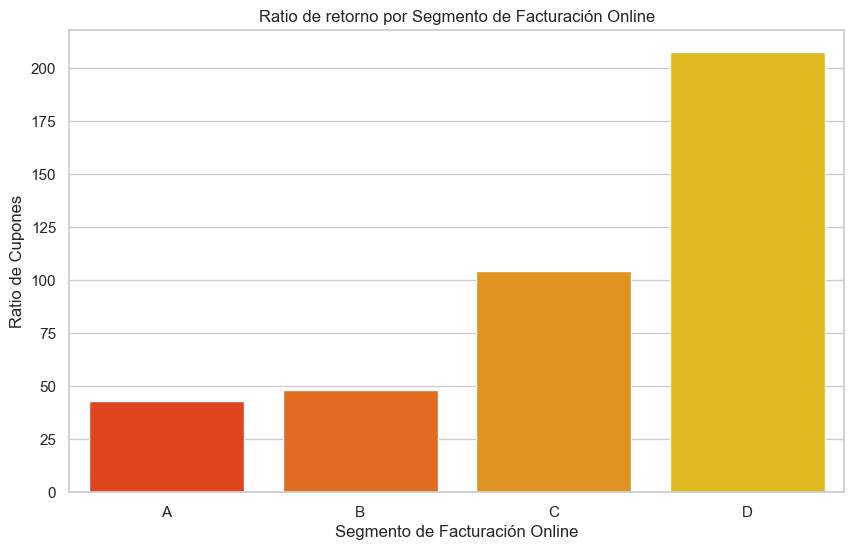

In [695]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
sns.set(style="whitegrid")

# 1. Gráfico de barras para Gasto en Cupones por Segmento
plt.figure(figsize=(10, 6))
sns.barplot(x='SegmentoFacturacionOnline', y='TotalCouponDiscountAmt', data=segmento_facturacion_stats, palette='cool')
plt.title('Gasto Total en Cupones por Segmento de Facturación Online')
plt.xlabel('Segmento de Facturación Online')
plt.ylabel('Gasto Total en Cupones')
plt.show()

# 2. Calcular y visualizar el ROI de Cupones por Segmento
segmento_facturacion_stats['Ratio_Cupones_Sellout'] = segmento_facturacion_stats['TotalSelloutOnline'] / segmento_facturacion_stats['TotalCouponDiscountAmt']
plt.figure(figsize=(10, 6))
sns.barplot(x='SegmentoFacturacionOnline', y='Ratio_Cupones_Sellout', data=segmento_facturacion_stats, palette='autumn')
plt.title('Ratio de retorno por Segmento de Facturación Online')
plt.xlabel('Segmento de Facturación Online')
plt.ylabel('Ratio de Cupones')
plt.show()



# Referencias unicas

In [696]:

# Verificar y normalizar 'CodeProduct' como antes para evitar problemas de listas o arrays
online_orders['CodeProduct'] = online_orders['CodeProduct'].apply(lambda x: x if isinstance(x, str) else ', '.join(map(str, x)) if isinstance(x, list) else x)
online_orders['CodeProduct'] = online_orders['CodeProduct'].astype(str)

# Calcular el número de referencias únicas por 'PointOfSaleId' para los pedidos online
referencias_unicas_online = online_orders.groupby('PointOfSaleId')['CodeProduct'].nunique().reset_index()

# Renombrar la columna para mayor claridad
referencias_unicas_online = referencias_unicas_online.rename(columns={'CodeProduct': 'NumeroReferenciasUnicas'})


max_referencias_unicas = referencias_unicas_online['NumeroReferenciasUnicas'].max()
max_referencias_unicas

151

In [697]:
# Calcular los percentiles para dividir en segmentos personalizados
percentiles = referencias_unicas_online['NumeroReferenciasUnicas'].quantile([0.1, 0.5, 0.9]).values

# Función para clasificar los PDVs en segmentos según el número de referencias únicas
def clasificar_referencias_unicas(numero_referencias):
    if numero_referencias >= percentiles[2]:
        return 'A'  # Top 10% de referencias únicas
    elif percentiles[1] <= numero_referencias < percentiles[2]:
        return 'B'  # Del 50% al 90%
    elif percentiles[0] <= numero_referencias < percentiles[1]:
        return 'C'  # Del 10% al 50%
    else:
        return 'D'  # Bottom 10%

# Aplicar la clasificación para cada PDV
referencias_unicas_online['SegmentoReferenciasUnicas'] = referencias_unicas_online['NumeroReferenciasUnicas'].apply(clasificar_referencias_unicas)

# Agrupar por 'SegmentoReferenciasUnicas' para calcular el mínimo y el máximo de referencias únicas en cada segmento
rango_referencias_por_segmento = referencias_unicas_online.groupby('SegmentoReferenciasUnicas')['NumeroReferenciasUnicas'].agg(['min', 'max']).reset_index()

# Renombrar las columnas para mayor claridad
rango_referencias_por_segmento.columns = ['SegmentoReferenciasUnicas', 'MinReferencias', 'MaxReferencias']


In [698]:


rango_referencias_por_segmento


,SegmentoReferenciasUnicas,MinReferencias,MaxReferencias
0,A,18,151
1,B,4,17
2,C,1,3


In [699]:
# Agrupar por el segmento 'SegmentoReferenciasUnicas' para calcular las métricas
segmento_referencias_stats = order_detail_sorted.groupby('SegmentoReferenciasUnicas').agg(
    NumeroPDVs=('PointOfSaleId', 'nunique'),  # Número de PDVs en cada segmento
    TotalCouponDiscountAmt=('CouponDiscountAmt', 'sum'),  # Gasto total en cupones
    PromedioCouponDiscountAmt=('CouponDiscountAmt', 'mean'),  # Gasto promedio en cupones
    TotalSellout=('Sellout', 'sum'),  # Facturación total
    PromedioSellout=('Sellout', 'mean')  # Facturación promedio
).reset_index()

# Filtrar registros con cupones para calcular el promedio sin contar los valores 0
cupon_sin0 = order_detail_sorted[order_detail_sorted['CouponDiscountAmt'] > 0]

# Calcular el promedio de 'CouponDiscountAmt' sin contar los valores que son 0 por cada 'SegmentoReferenciasUnicas'
promedio_cupon_sin0_segmento = cupon_sin0.groupby('SegmentoReferenciasUnicas')['CouponDiscountAmt'].mean().reset_index()

# Renombrar la columna para evitar conflicto al hacer el merge
promedio_cupon_sin0_segmento = promedio_cupon_sin0_segmento.rename(columns={'CouponDiscountAmt': 'PromedioCouponDiscountAmtSin0'})

# Hacer el merge para agregar la nueva columna al DataFrame 'segmento_referencias_stats'
segmento_referencias_stats = pd.merge(segmento_referencias_stats, promedio_cupon_sin0_segmento, on='SegmentoReferenciasUnicas', how='left')
segmento_facturacion_stats

KeyError: 'SegmentoReferenciasUnicas'

C:\Users\ctrujils\AppData\Local\Temp\ipykernel_3648\3317479982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SegmentoReferenciasUnicas', y='NumeroReferenciasUnicas', data=referencias_unicas_online, palette='coolwarm')
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\ctrujils\Documents\Proyectos\MSM\validador\ml-validator\b2b_env\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.t

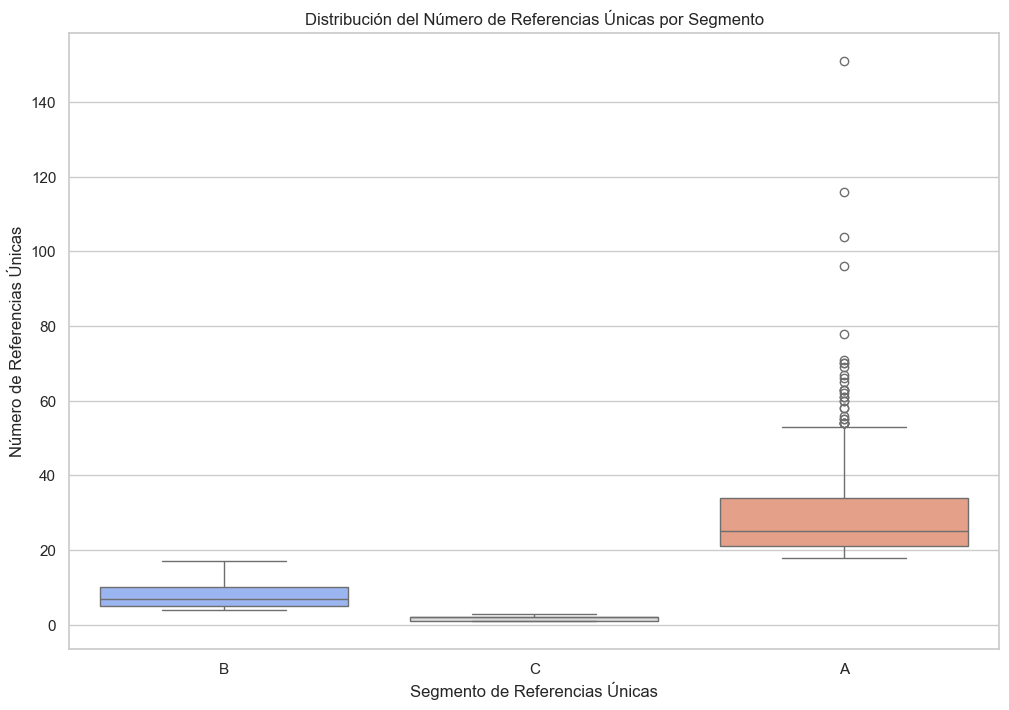

In [700]:
# Gráfico de caja y bigotes para visualizar la distribución del número de referencias por cada segmento
plt.figure(figsize=(12, 8))
sns.boxplot(x='SegmentoReferenciasUnicas', y='NumeroReferenciasUnicas', data=referencias_unicas_online, palette='coolwarm')
plt.title('Distribución del Número de Referencias Únicas por Segmento')
plt.xlabel('Segmento de Referencias Únicas')
plt.ylabel('Número de Referencias Únicas')
plt.show()


In [701]:
# Agrupar por 'SegmentoReferenciasUnicas' para calcular las métricas
segmento_referencias_stats = order_detail_sorted.groupby('SegmentoReferenciasUnicas').agg(
    TotalCouponDiscountAmt=('CouponDiscountAmt', 'sum'),  # Gasto total en cupones
    TotalSellout=('Sellout', 'sum'),  # Facturación total
).reset_index()

# Gráfico de barras comparativo
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Gasto en Cupones por Segmento
sns.barplot(x='SegmentoReferenciasUnicas', y='TotalCouponDiscountAmt', data=segmento_referencias_stats, ax=ax[0], palette='Blues')
ax[0].set_title('Gasto Total en Cupones por Segmento')
ax[0].set_xlabel('Segmento de Referencias Únicas')
ax[0].set_ylabel('Gasto Total en Cupones')

# Facturación por Segmento
sns.barplot(x='SegmentoReferenciasUnicas', y='TotalSellout', data=segmento_referencias_stats, ax=ax[1], palette='Greens')
ax[1].set_title('Facturación Total (Sellout) por Segmento')
ax[1].set_xlabel('Segmento de Referencias Únicas')
ax[1].set_ylabel('Facturación Total (Sellout)')

plt.tight_layout()
plt.show()


KeyError: 'SegmentoReferenciasUnicas'

In [702]:
order_detail_sorted.columns

Index(['Code', 'OrderDate', 'Sellout', 'CodeProduct', 'Name',
       'NameDistributor', 'PointOfSaleId', 'CouponCode', 'CouponDiscountAmt',
       'CouponDiscountPct', 'CouponDescription', 'InsertionOrigin', 'Origin',
       'tipologia', 'Cluster', 'Frequency_online', 'Coupon_type',
       'PctgCouponUsed', 'DaysBetweenPurchases',
       'CumulativeAvgDaysBetweenPurchases', 'IsOnline', 'LastPurchaseOnline',
       'Digitalizacion', 'ForwardOnline', 'NumberOfOrders_x', 'LastOrderDate',
       'LastOnlineOrderDate', 'NumberOfOrders_y',
       'DaysBetweenLastOrderAndLastOnline', 'Estado',
       'SegmentoFacturacionOnline'],
      dtype='object')

In [710]:
order_detail_sorted[order_detail_sorted['OrderDate'].apply(lambda x: x.year)==2023].groupby('NameDistributor')['CouponDiscountAmt'].sum().reset_index()


,NameDistributor,CouponDiscountAmt
0,Bebicer,0.000000
1,Voldis Coruña,71774.419996
2,Voldis Granada,144091.920040
3,Voldis Madrid,156853.849980
4,Voldis Murcia,72970.720011
5,Voldis Valencia,163839.309999


In [712]:
path=r'C:\Users\ctrujils\eficiencia_promocional\order_detail_sorted_segmentado_v2.parquet'
order_detail_sorted.to_parquet(path)